In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline

# Задача
## Cпрогнозировать опасность следующей смены в шахте

# Характеристики данных

Два класса  
Данные несбалансированы  
Данные разнородные

**Instances**: 2584  
**Attributes**: 18 + class  
**Class distribution**:  
"hazardous state" (class 1)    :  170  (6.6%)  
"non-hazardous state" (class 0): 2414 (93.4%)  
**Missing Attribute Values**: None

**Attribute information**:
1. seismic: result of shift seismic hazard assessment in the mine working obtained by the seismic  
method (a - lack of hazard, b - low hazard, c - high hazard, d - danger state);
2. seismoacoustic: result of shift seismic hazard assessment in the mine working obtained by the  
seismoacoustic method;
3. shift: information about type of a shift (W - coal-getting, N -preparation shift);
4. genergy: seismic energy recorded within previous shift by the most active geophone (GMax) out of  
geophones monitoring the longwall;
5. gpuls: a number of pulses recorded within previous shift by GMax;
6. gdenergy: a deviation of energy recorded within previous shift by GMax from average energy recorded  
during eight previous shifts;
7. gdpuls: a deviation of a number of pulses recorded within previous shift by GMax from average number  
of pulses recorded during eight previous shifts;
8. ghazard: result of shift seismic hazard assessment in the mine working obtained by the  
seismoacoustic method based on registration coming form GMax only;
9. nbumps: the number of seismic bumps recorded within previous shift;
10. nbumps2: the number of seismic bumps (in energy range [10^2,10^3)) registered within previous shift;
11. nbumps3: the number of seismic bumps (in energy range [10^3,10^4)) registered within previous shift;
12. nbumps4: the number of seismic bumps (in energy range [10^4,10^5)) registered within previous shift;
13. nbumps5: the number of seismic bumps (in energy range [10^5,10^6)) registered within the last shift;
14. nbumps6: the number of seismic bumps (in energy range [10^6,10^7)) registered within previous shift;
15. nbumps7: the number of seismic bumps (in energy range [10^7,10^8)) registered within previous shift;
16. nbumps89: the number of seismic bumps (in energy range [10^8,10^10)) registered within previous shift;
17. energy: total energy of seismic bumps registered within previous shift;
18. maxenergy: the maximum energy of the seismic bumps registered within previous shift;
19. class: the decision attribute - '1' means that high energy seismic bump occurred in the next shift  
('hazardous state'), '0' means that no high energy seismic bumps occurred in the next shift  
('non-hazardous state').

## Считывание данных

In [2]:
data = arff.loadarff('seismic-bumps.arff')
df = pd.DataFrame(data[0])

df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,b'a',b'a',b'N',15180.0,48.0,-72.0,-72.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1,b'a',b'a',b'N',14720.0,33.0,-70.0,-79.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,b'0'
2,b'a',b'a',b'N',8050.0,30.0,-81.0,-78.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
3,b'a',b'a',b'N',28820.0,171.0,-23.0,40.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,b'0'
4,b'a',b'a',b'N',12640.0,57.0,-63.0,-52.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'


# Предобработка данных
## Убираю столбцы nbumps6-9, так как они практически полностью нулевые

In [3]:
df = df.drop('nbumps6', axis = 1)\
            .drop('nbumps7', axis = 1)\
           .drop('nbumps89',    axis = 1)\
#.drop('nbumps', axis = 1)\
#.drop('nbumps2', axis = 1)\
#.drop('nbumps3', axis = 1)\
#.drop('nbumps4', axis = 1)\
#.drop('nbumps5', axis = 1)\

## Ищу категориальные и числовые признаки

In [4]:
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['seismic', 'seismoacoustic', 'shift', 'ghazard', 'class']
['genergy', 'gpuls', 'gdenergy', 'gdpuls', 'nbumps', 'nbumps2', 'nbumps3', 'nbumps4', 'nbumps5', 'energy', 'maxenergy']


## Декодирую данные в категориальных признаках

In [5]:
for c in categorical_columns:
    df[c] = df[c].str.decode(encoding = 'utf-8')

In [6]:
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy,class
0,a,a,N,15180.0,48.0,-72.0,-72.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,a,a,N,14720.0,33.0,-70.0,-79.0,a,1.0,0.0,1.0,0.0,0.0,2000.0,2000.0,0
2,a,a,N,8050.0,30.0,-81.0,-78.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,a,a,N,28820.0,171.0,-23.0,40.0,a,1.0,0.0,1.0,0.0,0.0,3000.0,3000.0,0
4,a,a,N,12640.0,57.0,-63.0,-52.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [7]:
print(df.shape)
print(df.columns)

(2584, 16)
Index(['seismic', 'seismoacoustic', 'shift', 'genergy', 'gpuls', 'gdenergy',
       'gdpuls', 'ghazard', 'nbumps', 'nbumps2', 'nbumps3', 'nbumps4',
       'nbumps5', 'energy', 'maxenergy', 'class'],
      dtype='object')


In [8]:
df.describe()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy
count,2.584000e+03,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,9.024252e+04,538.579334,12.375774,4.508901,0.859520,0.393576,0.392802,0.067724,0.004644,4975.270898,4278.850619
std,2.292005e+05,562.652536,80.319051,63.166556,1.364616,0.783772,0.769710,0.279059,0.068001,20450.833222,19357.454882
min,1.000000e+02,2.000000,-96.000000,-96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.166000e+04,190.000000,-37.000000,-36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.548500e+04,379.000000,-6.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.283250e+04,669.000000,38.000000,30.250000,1.000000,1.000000,1.000000,0.000000,0.000000,2600.000000,2000.000000
max,2.595650e+06,4518.000000,1245.000000,838.000000,9.000000,8.000000,7.000000,3.000000,1.000000,402000.000000,400000.000000


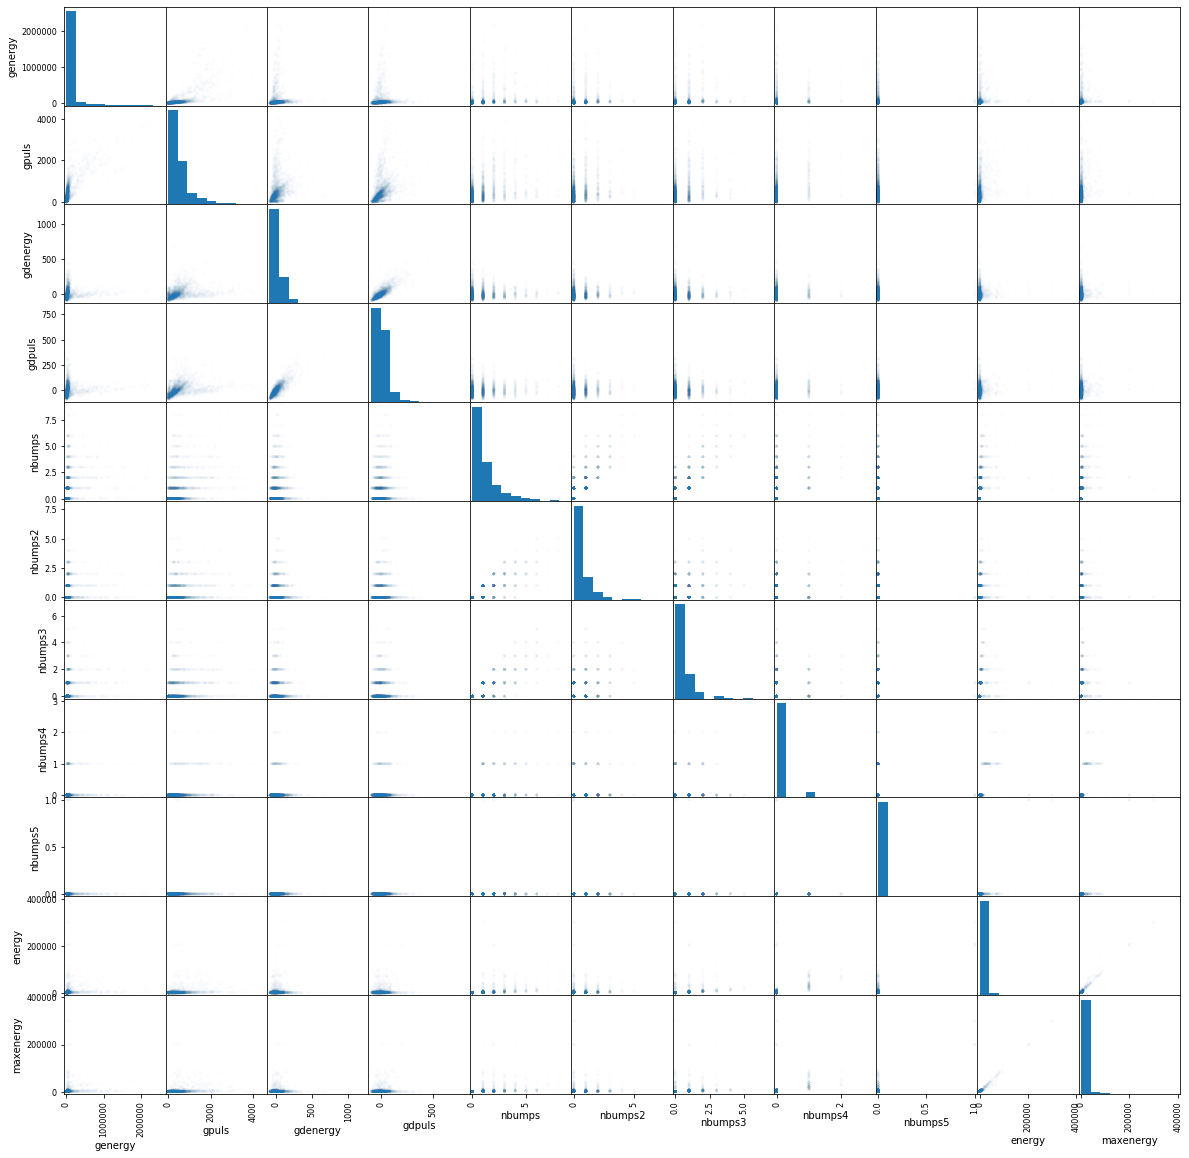

In [9]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha = .01, figsize = (20, 20))
pass

## Проверка данных на коррелированность

In [10]:
df.corr()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy
genergy,1.000000,0.748020,0.048514,0.071554,0.220720,0.143587,0.191753,0.150589,-0.009863,0.080828,0.064405
gpuls,0.748020,1.000000,0.293036,0.382906,0.300923,0.207390,0.225695,0.256547,0.049450,0.187350,0.164263
gdenergy,0.048514,0.293036,1.000000,0.811944,0.030039,0.041246,-0.012189,0.036916,0.123229,0.105971,0.108572
gdpuls,0.071554,0.382906,0.811944,1.000000,0.057996,0.051106,0.014735,0.066195,0.141044,0.143277,0.143646
nbumps,0.220720,0.300923,0.030039,0.057996,1.000000,0.804978,0.803364,0.395052,0.069613,0.347852,0.273714
nbumps2,0.143587,0.207390,0.041246,0.051106,0.804978,1.000000,0.350724,0.161296,-0.005251,0.124650,0.085032
nbumps3,0.191753,0.225695,-0.012189,0.014735,0.803364,0.350724,1.000000,0.175301,0.046498,0.244083,0.176480
nbumps4,0.150589,0.256547,0.036916,0.066195,0.395052,0.161296,0.175301,1.000000,-0.016580,0.489828,0.416483
nbumps5,-0.009863,0.049450,0.123229,0.141044,0.069613,-0.005251,0.046498,-0.016580,1.000000,0.773605,0.808406
energy,0.080828,0.187350,0.105971,0.143277,0.347852,0.124650,0.244083,0.489828,0.773605,1.000000,0.989547


## Проверка данных на пропущенные значения

In [11]:
df.isnull().values.any()

False

In [12]:
#df['seismic'].value_counts().plot.barh();

In [13]:
#df['seismoacoustic'].value_counts().plot.barh();

In [14]:
df.describe(include = 'all')

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy,class
count,2584,2584,2584,2.584000e+03,2584.000000,2584.000000,2584.000000,2584,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584
unique,2,3,2,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,a,a,W,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
freq,1682,1580,1663,NaN,NaN,NaN,NaN,2342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2414
mean,NaN,NaN,NaN,9.024252e+04,538.579334,12.375774,4.508901,NaN,0.859520,0.393576,0.392802,0.067724,0.004644,4975.270898,4278.850619,NaN
std,NaN,NaN,NaN,2.292005e+05,562.652536,80.319051,63.166556,NaN,1.364616,0.783772,0.769710,0.279059,0.068001,20450.833222,19357.454882,NaN
min,NaN,NaN,NaN,1.000000e+02,2.000000,-96.000000,-96.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,1.166000e+04,190.000000,-37.000000,-36.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,NaN,NaN,NaN,2.548500e+04,379.000000,-6.000000,-6.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,NaN,NaN,NaN,5.283250e+04,669.000000,38.000000,30.250000,NaN,1.000000,1.000000,1.000000,0.000000,0.000000,2600.000000,2000.000000,NaN


In [15]:
#seismic_unique = df['seismic'].unique()
#seismic_unique.insert
#for c in categorical_columns:
    #print(c, df[c].unique())
#print(seismic_unique)

In [16]:
df_describe = df.describe(include = [object])
#for c in categorical_columns:
#    df[c] = df[c].fillna(df_describe[c]['top'])

## Обработка категориальных данных
Разделяю категориальные признаки на бинарные и небинарные

In [17]:
binary_columns    = [c for c in categorical_columns if df_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if df_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

['seismic', 'shift', 'class'] ['seismoacoustic', 'ghazard']


In [18]:
df['seismic'].unique()

array(['a', 'b'], dtype=object)

In [19]:
df.at[df['shift'] == 'N', 'shift'] = 0
df.at[df['shift'] == 'W', 'shift'] = 1
df['shift'].describe()

count    2584.000000
mean        0.643576
std         0.479035
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: shift, dtype: float64

In [20]:
df.at[df['seismic'] == 'a', 'seismic'] = 0
df.at[df['seismic'] == 'b', 'seismic'] = 1
df['seismic'].describe()

count    2584.000000
mean        0.349071
std         0.476769
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: seismic, dtype: float64

In [21]:
#df[nonbinary_columns]

Применяю one hot encoding к небинарным категориальным признакам

In [22]:
df_nonbinary = pd.get_dummies(df[nonbinary_columns])
print(df_nonbinary.columns)

Index(['seismoacoustic_a', 'seismoacoustic_b', 'seismoacoustic_c', 'ghazard_a',
       'ghazard_b', 'ghazard_c'],
      dtype='object')


In [23]:
len(df_nonbinary.columns)

6

## Обработка числовых признаков
Выделяю числовые признаки

In [24]:
df_numerical = df[numerical_columns]
df_numerical.describe()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy
count,2.584000e+03,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,9.024252e+04,538.579334,12.375774,4.508901,0.859520,0.393576,0.392802,0.067724,0.004644,4975.270898,4278.850619
std,2.292005e+05,562.652536,80.319051,63.166556,1.364616,0.783772,0.769710,0.279059,0.068001,20450.833222,19357.454882
min,1.000000e+02,2.000000,-96.000000,-96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.166000e+04,190.000000,-37.000000,-36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.548500e+04,379.000000,-6.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.283250e+04,669.000000,38.000000,30.250000,1.000000,1.000000,1.000000,0.000000,0.000000,2600.000000,2000.000000
max,2.595650e+06,4518.000000,1245.000000,838.000000,9.000000,8.000000,7.000000,3.000000,1.000000,402000.000000,400000.000000


Нормализую числовые признаки

In [25]:
df_numerical = (df_numerical - df_numerical.mean(axis = 0))/df_numerical.std(axis = 0)
df_numerical.describe()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy
count,2.584000e+03,2.584000e+03,2.584000e+03,2584.000000,2.584000e+03,2.584000e+03,2.584000e+03,2.584000e+03,2.584000e+03,2584.000000,2.584000e+03
mean,-2.199823e-17,5.499557e-17,-4.399645e-17,0.000000,-2.199823e-17,-4.399645e-17,2.199823e-17,-4.399645e-17,1.649867e-17,0.000000,-1.649867e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
min,-3.932911e-01,-9.536602e-01,-1.349316e+00,-1.591173,-6.298621e-01,-5.021560e-01,-5.103247e-01,-2.426888e-01,-6.829220e-02,-0.243280,-2.210441e-01
25%,-3.428549e-01,-6.195286e-01,-6.147455e-01,-0.641303,-6.298621e-01,-5.021560e-01,-5.103247e-01,-2.426888e-01,-6.829220e-02,-0.243280,-2.210441e-01
50%,-2.825366e-01,-2.836197e-01,-2.287848e-01,-0.166368,-6.298621e-01,-5.021560e-01,-5.103247e-01,-2.426888e-01,-6.829220e-02,-0.243280,-2.210441e-01
75%,-1.632196e-01,2.317961e-01,3.190305e-01,0.407512,1.029446e-01,7.737252e-01,7.888664e-01,-2.426888e-01,-6.829220e-02,-0.116145,-1.177247e-01
max,1.093107e+01,7.072608e+00,1.534660e+01,13.195133,5.965398e+00,9.704893e+00,8.584013e+00,1.050773e+01,1.463729e+01,19.413621,2.044283e+01


## Собираю обработанные данные

In [26]:
df = pd.concat((df_numerical, df_nonbinary, df[binary_columns]), axis = 1)
print(df.shape)

(2584, 20)


In [27]:
df.isnull().values.any()

False

## Подготовка данных для классификатора
выбрасываю столбец 'class'

In [28]:
X = df.drop('class', axis = 1)
y = df['class']
feature_names = X.columns

In [29]:
feature_names

Index(['genergy', 'gpuls', 'gdenergy', 'gdpuls', 'nbumps', 'nbumps2',
       'nbumps3', 'nbumps4', 'nbumps5', 'energy', 'maxenergy',
       'seismoacoustic_a', 'seismoacoustic_b', 'seismoacoustic_c', 'ghazard_a',
       'ghazard_b', 'ghazard_c', 'seismic', 'shift'],
      dtype='object')

In [30]:
X = X.to_numpy()

In [31]:
print(y)

0       0
1       0
2       0
3       0
4       0
       ..
2579    0
2580    0
2581    0
2582    0
2583    0
Name: class, Length: 2584, dtype: object


In [32]:
y = y.to_numpy()

In [33]:
print(X.shape)
print(y.shape)
N, d = X.shape

(2584, 19)
(2584,)


In [34]:
type(X)

numpy.ndarray

In [35]:
type(y)

numpy.ndarray

## Разделяю данные на обучающую и тестовую

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

1550 1034


# Применение различных методов
## Метод k-ближайших соседей

In [37]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
#knn.set_params(n_neighbors=10)
knn.fit(X_train, y_train)

knn_predicted = knn.predict(X_test)
print(np.mean(y_test  != knn_predicted))
print(confusion_matrix(y_test, knn_predicted))
print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

0.06576402321083172
[[961   2]
 [ 66   5]]
0.9354838709677419
0.9342359767891683


In [38]:
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.06387096774193546 10


## SVM

In [39]:
from sklearn.svm import SVC
svc = SVC(gamma='auto', class_weight='balanced')
svc.fit(X_train, y_train)

svc_predicted = svc.predict(X_test)
print(np.mean(y_test  != svc_predicted))
print(confusion_matrix(y_test, svc_predicted))
print(1 - svc.score(X_train, y_train))
print(1 - svc.score(X_test, y_test))

0.28433268858800775
[[695 268]
 [ 26  45]]
0.25161290322580643
0.28433268858800775


In [40]:
Cs = 10.**np.arange(-5, 5)
gamma_array = 10.**np.arange(-5, 5)
svc = SVC(gamma='auto', class_weight='balanced')
grid = GridSearchCV(svc, cv=3, param_grid = {'C': Cs, 'gamma': gamma_array})
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_C = grid.best_estimator_.C
print(best_cv_err, best_C)

0.06387096774193546 1e-05


D:\Anaconda\envs\seismic\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Выводы
- метод ближайших соседей работает очень плохо при разном количестве соседей (скорее всего потому что  
выборка несбалансированная)
- нужно как-то сбалансировать выборку
- svс показывает вменяемые результаты, но тоже довольно плохие (true positive и true negative больше,  
чем false positive и false negative, но результаты оставляют желать лучшего)
- нужно попробовать задать словарь с ограничениями и большим штрафом на false negative

# Метод главных компонент
## Сокращаю размерность пространства до 2-х и применяю к обработанным данным

In [41]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df[['class']]], axis = 1)

In [42]:
finalDf.head()

,principal component 1,principal component 2,class
0,-1.593745,0.680309,0
1,-0.884348,0.116802,0
2,-1.644500,0.691759,0
3,-0.317462,0.135682,0
4,-1.514999,0.690262,0


## График точек после сокращения размерности

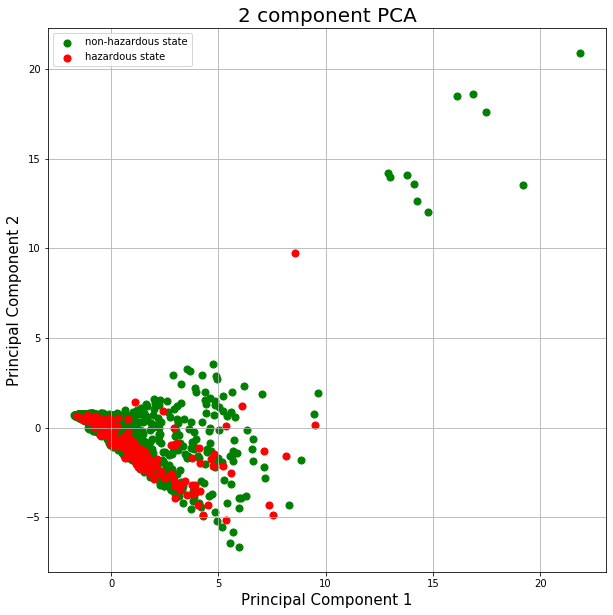

In [43]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0', '1']
colors = ['g', 'r']
states = ['non-hazardous state', 'hazardous state']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(states)
ax.grid()

## Применяю SVM

In [44]:
X = finalDf.drop('class', axis = 1)
y = finalDf['class']
feature_names = X.columns
feature_names

Index(['principal component 1', 'principal component 2'], dtype='object')

In [45]:
X = X.to_numpy()

In [46]:
y = y.to_numpy()

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

1550 1034


In [48]:
svc = SVC(gamma='auto', class_weight='balanced')
svc.fit(X_train, y_train)

svc_predicted = svc.predict(X_test)
print(np.mean(y_test  != svc_predicted))
print(confusion_matrix(y_test, svc_predicted))
print(svc.score(X_train, y_train))
print(svc.score(X_test, y_test))

0.21470019342359767
[[769 194]
 [ 28  43]]
0.7993548387096774
0.7852998065764023


## Функция для вычисления ошибок на тестовой и обучающей выборках в зависимости от количества используемых компонент

In [51]:
def my_pca(df, pca_numbers):
    train_errors = []
    test_errors = []
    for pca_number in pca_numbers:
        pca = PCA(n_components=pca_number)
        principalComponents = pca.fit_transform(df)
        pca_names = []
        for i in range(1,pca_number+1):
            pca_names.append('principal component' + str(i))
        principalDf = pd.DataFrame(data = principalComponents, columns = pca_names)
        finalDf = pd.concat([principalDf, df[['class']]], axis = 1)
        X = finalDf.drop('class', axis = 1)
        y = finalDf['class']
        X = X.to_numpy()
        y = y.to_numpy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)
        N_train, _ = X_train.shape 
        N_test,  _ = X_test.shape
        svc = SVC(gamma='auto', class_weight='balanced')
        svc.fit(X_train, y_train)
        svc_predicted = svc.predict(X_test)
        train_errors.append(1 - svc.score(X_train, y_train))
        test_errors.append(1 - svc.score(X_test, y_test))
        print('pca number = ' + str(i))
        print(1 - svc.score(X_train, y_train))
        print(1 - svc.score(X_test, y_test))
        #print(np.mean(y_test  != svc_predicted))
        #print(confusion_matrix(y_test, svc_predicted))
        #print()
    return (train_errors, test_errors)

In [52]:
number_of_pcas = list(range(2,20))
train_e, test_e = my_pca(df, number_of_pcas)
#print(train_e)
#print(test_e)

pca number = 2
0.20064516129032262
0.2147001934235977
pca number = 3
0.18903225806451618
0.23500967117988392
pca number = 4
0.15870967741935482
0.20793036750483562
pca number = 5
0.1619354838709678
0.20889748549323017
pca number = 6
0.15741935483870972
0.2147001934235977
pca number = 7
0.15806451612903227
0.21276595744680848
pca number = 8
0.15677419354838706
0.2292069632495164
pca number = 9
0.15677419354838706
0.23694390715667313
pca number = 10
0.17161290322580647
0.2437137330754352
pca number = 11
0.19032258064516128
0.2620889748549323
pca number = 12
0.18774193548387097
0.2514506769825918
pca number = 13
0.18903225806451618
0.25338491295938104
pca number = 14
0.000645161290322549
0.007736943907156624
pca number = 15
0.000645161290322549
0.007736943907156624
pca number = 16
0.000645161290322549
0.007736943907156624
pca number = 17
0.000645161290322549
0.0067698259187620735
pca number = 18
0.000645161290322549
0.005802707930367523
pca number = 19
0.0
0.005802707930367523


 ## График зависимости ошибки на тестовой и обучающей выборках в зависимости от количества используемых компонент

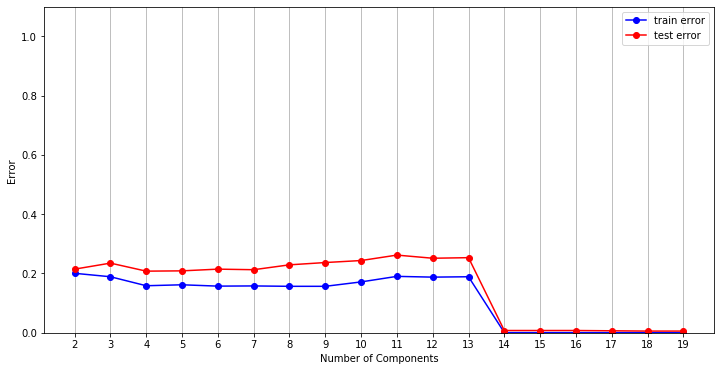

In [55]:
fig, ax = plt.subplots()
xi = number_of_pcas

plt.ylim(0.0,1.1)
plt.plot(xi, train_e, marker='o', color='b', label='train error')
plt.plot(xi, test_e, marker='o', color='r', label='test error')
plt.legend()

plt.xlabel('Number of Components')
plt.xticks(number_of_pcas)
plt.ylabel('Error')

ax.grid(axis='x')
plt.show()

# График объяснённой дисперсии

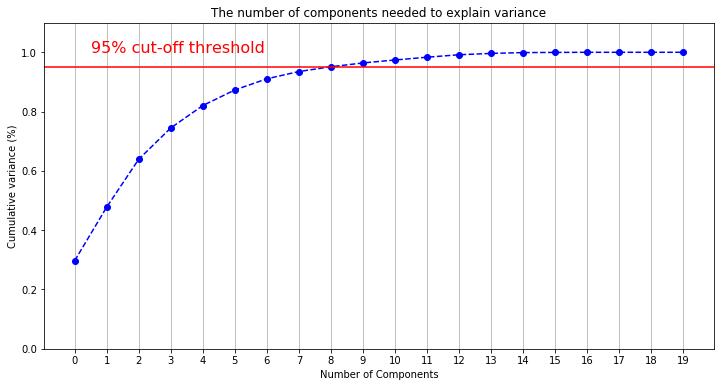

In [54]:
pca1 = PCA().fit(df)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = list(range(0,20))
y = np.cumsum(pca1.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(xi) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 1.0, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

# Выводы

Для моих данных SVM был лучшим классификатором  
- без PCA ошибки были:  
0.25161290322580643 для обучающей выборки  
0.28433268858800775 для тестовой выборки  
- с PCA самая маленькая ошибка на тестовой выборке получилась при 8 главных компонентах:  
pca number = 8  
0.15677419354838706 для обучающей выборки  
0.2292069632495164 для тестовой выборки  
  
Ошибка снизилась

# Обучение неглубокой полносвязной нейронной сети

In [41]:
from sklearn.neural_network import MLPClassifier

In [42]:
alpha = 0.0001
size = (100,)
solver = 'lbfgs'
activation = 'logistic'
random_state = 42

## Обучаю классификатор

In [43]:
def build_model(alpha, size, solver, activation, random_state):
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = size, solver = solver, 
                          activation = activation, random_state = random_state, shuffle=True)
    mlp_model.fit(X_train, y_train)
    return mlp_model

In [44]:
mlp_model = build_model(alpha, size, solver, activation, random_state)

## Проверяю качество классфикатора

In [45]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [46]:
print(mlp_model.score(X_train, y_train), mlp_model.score(X_test, y_test))

1.0 0.8704061895551257


In [47]:
print(1 - mlp_model.score(X_test, y_test))

0.12959381044487428


## Подбор гиперпараметров

In [48]:
#parameters = {'solver': ['lbfgs'],
#              'alpha': 10.0 ** -np.arange(1, 7), 
#              'hidden_layer_sizes':np.arange(50, 200), 
#              'random_state':[42]}
#grid = GridSearchCV(mlp_model, parameters, cv=5)
#grid.fit(X_train, y_train)

# Best paramete set
#print('Best parameters found:\n', grid.best_params_)

#best_cv_err = 1 - grid.best_score_
#print(best_cv_err)

In [49]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = build_model(alpha, size, solver, activation, random_state)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

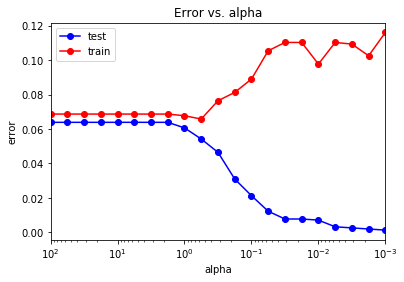

In [50]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'test')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'train')
plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

## Минимальные значения ошибок

In [53]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.0012903225806451613 0.06576402321083172


## Оптимальное альфа

In [54]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[0.56234133]


In [55]:
alpha_opt = alpha_opt[0]

## Обучаю классификатор с оптимальной альфа

In [56]:
mlp_model = build_model(alpha_opt, size, solver, activation, random_state)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.05419354838709677
0.06576402321083172


## Матрица рассогласования и другие метрики

In [58]:
print(confusion_matrix(y_test, y_test_pred))

[[958   5]
 [ 63   8]]


In [59]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       963
           1       0.62      0.11      0.19        71

    accuracy                           0.93      1034
   macro avg       0.78      0.55      0.58      1034
weighted avg       0.92      0.93      0.91      1034



# Классификатор с данными, к которым применён PCA
Взял 8 главных компонент

In [60]:
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(df)
pca_names = []
for i in range(1,9):
            pca_names.append('principal component' + str(i))
principalDf = pd.DataFrame(data = principalComponents, columns = pca_names)
finalDf = pd.concat([principalDf, df[['class']]], axis = 1)
X = finalDf.drop('class', axis = 1)
y = finalDf['class']
X = X.to_numpy()
y = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)
N_train, _ = X_train.shape 
N_test,  _ = X_test.shape

## Обучаю

In [61]:
mlp_model = build_model(alpha, size, solver, activation, random_state)

## Проверяю качество

In [62]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [63]:
print(mlp_model.score(X_train, y_train), mlp_model.score(X_test, y_test))

0.9361290322580645 0.9313346228239845


In [64]:
print(1 - mlp_model.score(X_test, y_test))

0.06866537717601551


## Подбираю гиперпараметры

In [65]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = build_model(alpha, size, solver, activation, random_state)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

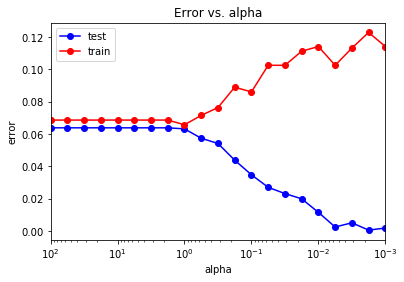

In [66]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'test')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'train')
plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

In [67]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.0006451612903225806 0.06576402321083172


In [68]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[1.]


In [69]:
alpha_opt = alpha_opt[0]

## Снова обучаю с оптимальным альфа

In [70]:
mlp_model = build_model(alpha_opt, size, solver, activation, random_state)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.06322580645161291
0.06576402321083172


## Матрица рассогласования и другие метрики

In [71]:
print(confusion_matrix(y_test, y_test_pred))

[[962   1]
 [ 67   4]]


In [72]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97       963
           1       0.80      0.06      0.11        71

    accuracy                           0.93      1034
   macro avg       0.87      0.53      0.54      1034
weighted avg       0.93      0.93      0.91      1034



# Выводы

- с PCA = 8 количество правильно предсказанных элементов первого класса увеличилось, но немного уменьшилось количество правильно предсказанных элементов второго класса